In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix, issparse

import networkx as nx

import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Union

init_seed = 739

### Utilities: build & parse

In [2]:
def build_adj_from_edge_list(n: int, edges, directed=True):
    """
    Build adjacency CSR using networkx. edges = list of (u,v,weight).
    Returns csr_matrix A with A[i,j] = weight of i -> j.
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # add nodes (ensures nodes 0..n-1 exist)
    G.add_nodes_from(range(n))
    # add weighted edges
    # networkx expects weight argument name 'weight'
    G.add_weighted_edges_from(edges)

    # extract sparse adjacency in row-major (rows = source nodes)
    # nx.to_scipy_sparse_array (or nx.to_scipy_sparse_matrix in older nx) yields a matrix
    A = nx.to_scipy_sparse_array(G, nodelist=range(n), weight='weight', format='csr')
    return A

def stochastic_block_model_directed_weighted(sizes,
                                                p_in: float,
                                                p_out: float,
                                                weight_in_scale: float = 1.0,
                                                weight_out_scale: float = 0.2,
                                                self_loops: bool = False,
                                                seed: int = None):
    """
    Build directed stochastic-block weighted adjacency using networkx.
    Returns (A_csr, blocks_array) where blocks_array[u] = block index of node u.
    """
    rng = np.random.default_rng(seed)
    n = sum(sizes)
    # build probability matrix (block x block)
    k = len(sizes)
    p_matrix = [[(p_in if i == j else p_out) for j in range(k)] for i in range(k)]

    # nx.stochastic_block_model allows directed=True and selfloops flag
    G = nx.stochastic_block_model(sizes, p_matrix, directed=True, selfloops=self_loops, seed=seed)
    # nodes are labeled 0..n-1 in order, blocks can be reconstructed from sizes
    blocks = np.repeat(np.arange(k), sizes)

    # assign weights: for each edge (u,v) sample weight depending on same_block
    # use exponential as before
    for u, v in list(G.edges()):
        same = (blocks[u] == blocks[v])
        scale = weight_in_scale if same else weight_out_scale
        G[u][v]['weight'] = float(rng.exponential(scale=scale))

    # create CSR adjacency (A[i,j] = weight i->j)
    A = nx.to_scipy_sparse_array(G, nodelist=range(n), weight='weight', format='csr')

    return A, blocks

def parse_partition(partition: Union[List[int], Dict[int, List[int]], List[List[int]]],
                    n: int) -> np.ndarray:
    """
    Accepts several partition forms and returns an array of length n mapping node -> module index (0..m-1):
      - array-like of length n with module indices
      - dict {module_label: [nodes,...]}
      - list of lists: [[nodes_of_module0], [nodes_of_module1], ...]
    """
    if partition is None:
        raise ValueError("partition cannot be None")

    # Case 1: array-like
    try:
        arr = np.asarray(partition)
        if arr.ndim == 1 and arr.size == n and np.issubdtype(arr.dtype, np.integer):
            return arr.astype(int)
    except Exception:
        pass

    # Case 2: dict or list-of-lists
    result = np.full(n, -1, dtype=int)
    if isinstance(partition, dict):
        items = partition.items()
    elif isinstance(partition, (list, tuple)):
        # assume list-of-lists: each item is a list of node ids (or integers)
        items = enumerate(partition)
    else:
        raise ValueError("Unsupported partition format")

    idx = 0
    for key, nodes in items:
        for u in nodes:
            result[int(u)] = idx
        idx += 1

    if (result < 0).any():
        missing = np.where(result < 0)[0]
        raise ValueError(f"Partition does not assign these nodes: {missing.tolist()}")
    return result

### Transition matrix & Power method

In [3]:
def row_stochastic_from_adj(A):
    """
    Convert adjacency matrix A (n x n) with A[i,j] = weight i -> j
    into a row-stochastic transition matrix T (csr_matrix).
    Dangling rows (rows with sum 0) remain zero-rows.
    Works for sparse or dense A.
    """
    if sparse.issparse(A):
        A = A.tocsr()
        row_sums = np.array(A.sum(axis=1)).ravel()
        inv = np.zeros_like(row_sums, dtype=float)
        nz = row_sums > 0
        inv[nz] = 1.0 / row_sums[nz]
        Dinv = sparse.diags(inv)
        T = Dinv.dot(A)
    else:
        A = np.asarray(A, dtype=float)
        row_sums = A.sum(axis=1)
        T = np.zeros_like(A)
        nz = row_sums > 0
        T[nz] = (A[nz].T / row_sums[nz]).T
        T = csr_matrix(T)
    return T

def power_method_stationary(A, epsilon=0.15, tol=1e-12, maxiter=10000, verbose=False):
    """
    Compute stationary distribution pi as a numpy array using networkx.pagerank.
    - A: adjacency (scipy csr or networkx Graph/DiGraph). If scipy matrix is given, convert to DiGraph.
    - epsilon: teleportation probability (teleport prob). nx.pagerank uses damping alpha = 1 - epsilon.
    Returns pi (1d numpy array length n).
    """
    # If input is sparse adjacency, convert to networkx DiGraph
    if issparse(A):
        # convert sparse adjacency to DiGraph preserving weights
        # nx.from_scipy_sparse_array returns Graph (undirected) for symmetric; for adjacency it supports create_using
        G = nx.from_scipy_sparse_array(A, parallel_edges=False, create_using=nx.DiGraph)
    elif isinstance(A, (nx.Graph, nx.DiGraph)):
        G = A
    else:
        # assume dense numpy array
        G = nx.from_numpy_array(np.asarray(A), create_using=nx.DiGraph)

    alpha = 1.0 - epsilon  # damping factor used by networkx pagerank
    # Use nx.pagerank (power iteration) — it respects 'weight' edge attribute
    pr = nx.pagerank(G, alpha=alpha, max_iter=maxiter, tol=tol, weight='weight')
    # pr is dict node->score; ensure ordering 0..n-1
    n = G.number_of_nodes()
    pi = np.array([pr[i] for i in range(n)], dtype=float)
    # normalize to be safe
    pi = pi / pi.sum()
    return pi

### Map equation for flat partition

In [4]:
def entropy(probs, base=2.0):
    probs = np.asarray(probs, dtype=float)
    probs = probs[probs > 0]
    if probs.size == 0:
        return 0.0
    return -np.sum(probs * np.log(probs) / np.log(base))

def map_equation_L(A,
                   partition,
                   pi: np.ndarray = None,
                   epsilon: float = 0.15,
                   return_components: bool = False):
    """
    Compute map equation L for adjacency A (weighted,directed) and a flat partition.

    partition: can be array-like (node->module), dict or list-of-lists (see parse_partition).
    pi: optional stationary distribution (if None, computed here).
    """
    if sparse.issparse(A):
        n = A.shape[0]
    else:
        A = np.asarray(A, dtype=float)
        n = A.shape[0]

    part_arr = parse_partition(partition, n)
    modules, inverse = np.unique(part_arr, return_inverse=True)
    m = modules.size

    T = row_stochastic_from_adj(A)
    if pi is None:
        pi = power_method_stationary(A, epsilon=epsilon)

    # indicator matrix for modules (n x m)
    rows = np.arange(n)
    cols = inverse
    data = np.ones(n, dtype=float)
    indicator = sparse.csr_matrix((data, (rows, cols)), shape=(n, m))

    # T.dot(indicator) gives for each node a and module j: sum_{b in module j} T[a,b]
    T_to_modules = T.dot(indicator).toarray()  # shape (n,m)

    module_sizes = np.bincount(inverse, minlength=m)

    # P_to_modules (including teleportation)
    uniform_module_mass = module_sizes.astype(float) / float(n)
    P_to_modules = (1.0 - epsilon) * T_to_modules + epsilon * uniform_module_mass[np.newaxis, :]

    # q_i: exit probability per step from module i
    q_i = np.zeros(m, dtype=float)
    for a in range(n):
        mod_a = inverse[a]
        prob_leave_from_a = 1.0 - P_to_modules[a, mod_a]
        q_i[mod_a] += pi[a] * prob_leave_from_a

    q_total = q_i.sum()
    sum_pi_in_module = np.zeros(m, dtype=float)
    p_i = np.zeros(m, dtype=float)
    for j in range(m):
        mask = (inverse == j)
        sum_pi_in_module[j] = pi[mask].sum()
        p_i[j] = q_i[j] + sum_pi_in_module[j]

    H_Q = 0.0
    if q_total > 0:
        H_Q = entropy(q_i / q_total)

    H_Pi = np.zeros(m, dtype=float)
    for j in range(m):
        if p_i[j] <= 0:
            H_Pi[j] = 0.0
            continue
        probs = []
        if q_i[j] > 0:
            probs.append(q_i[j] / p_i[j])
        node_mask = (inverse == j)
        if node_mask.any():
            node_probs = pi[node_mask] / p_i[j]
            probs.extend(node_probs.tolist())
        probs = np.asarray(probs, dtype=float)
        H_Pi[j] = entropy(probs)

    L = q_total * H_Q + np.sum(p_i * H_Pi)

    if return_components:
        return {
            'L': L,
            'q_i': q_i,
            'q_total': q_total,
            'p_i': p_i,
            'sum_pi_in_module': sum_pi_in_module,
            'H_Q': H_Q,
            'H_Pi': H_Pi,
            'partition_mapping': part_arr
        }
    else:
        return L

### Evaluate two-level partition

In [5]:
def map_equation_two_level(A, top_partition, subpartitions, epsilon=0.15, return_components=False):
    """
    Evaluate map equation for a two-level partition:
      - top_partition: mapping node->top-module (array-like/dict/list)
      - subpartitions: dict mapping top_module_index -> partition-within-that-module
          each subpartition can be a list-of-lists of node indices (local to global node ids),
          or a dict or array-like mapping nodes->submodule ids (global indices).
    This constructs a flat partition that assigns a unique id for each submodule across top modules,
    then computes L using map_equation_L.
    Note: This is a convenience helper — the full hierarchical map equation (recursive codebooks)
          is more elaborate; here we simply evaluate the two-level partition as a flat partition
          of submodules (which is a common way to compare nested partitions).
    """
    if sparse.issparse(A):
        n = A.shape[0]
    else:
        n = np.asarray(A).shape[0]

    top_arr = parse_partition(top_partition, n)

    # Build global submodule assignment array:
    global_sub_assign = np.full(n, -1, dtype=int)
    next_id = 0
    # subpartitions should provide the internal partitioning for nodes in each top module
    for top_mod in np.unique(top_arr):
        if top_mod not in subpartitions:
            # treat whole top module as a single submodule
            nodes = np.where(top_arr == top_mod)[0].tolist()
            sub_list = [nodes]
        else:
            sub_list = subpartitions[top_mod]
            # allow dict or list-of-lists
            if isinstance(sub_list, dict):
                sub_list = list(sub_list.values())
        # assign ids
        for sub in sub_list:
            for u in sub:
                if top_arr[u] != top_mod:
                    raise ValueError(f"Node {u} assigned to submodule for top module {top_mod} but top partition says {top_arr[u]}")
                global_sub_assign[int(u)] = next_id
            next_id += 1

    if (global_sub_assign < 0).any():
        missing = np.where(global_sub_assign < 0)[0]
        raise ValueError(f"Some nodes were not assigned to any submodule: {missing.tolist()}")

    # Now compute map_equation on the flat partition given by global_sub_assign
    return map_equation_L(A, global_sub_assign, pi=None, epsilon=epsilon, return_components=return_components)


In [6]:
def normalize_partition_labels(part_arr):
    """
    Map arbitrary integer labels to a compact 0..m-1 range.
    Input: array-like length n with integer module labels (may be non-consecutive).
    Returns: numpy array length n with labels remapped to 0..m-1.
    """
    arr = np.asarray(part_arr, dtype=int)
    unique = np.unique(arr)
    mapping = {old: new for new, old in enumerate(unique)}
    return np.array([mapping[x] for x in arr], dtype=int)

def ensure_full_partition(partition_candidate, n):
    """
    Given a partition in one of accepted forms (array, dict, list-of-lists),
    guarantee it assigns every node in 0..n-1. If nodes are missing,
    assign missing nodes to existing modules (or create new module 0 if none exist).
    Returns a normalized array mapping node->module with labels 0..m-1.
    """
    # quick attempt to parse using your parse_partition if already valid
    try:
        arr = parse_partition(partition_candidate, n)
        # normalize labels to 0..m-1
        return normalize_partition_labels(arr)
    except Exception as e:
        # parse_partition failed → try to be forgiving and build from dict/list/array manually
        # If it's dict/list-of-lists build a dict mapping module->list(nodes)
        part_dict = {}
        if isinstance(partition_candidate, dict):
            part_dict = {int(k): [int(u) for u in v] for k,v in partition_candidate.items()}
        elif isinstance(partition_candidate, (list, tuple, np.ndarray)):
            # If it's a 1D array-like of length n with ints, use it.
            arr = np.asarray(partition_candidate)
            if arr.ndim == 1 and arr.size == n:
                return normalize_partition_labels(arr.astype(int))
            # else assume list-of-lists
            else:
                for i,sub in enumerate(partition_candidate):
                    part_dict[i] = [int(u) for u in sub]
        else:
            raise ValueError("Unsupported partition_candidate type in ensure_full_partition")

        # Build a node->module mapping and detect missing nodes
        node_to_mod = {}
        for mod, nodes in part_dict.items():
            for u in nodes:
                node_to_mod[int(u)] = int(mod)

        # Fill missing nodes: assign them to the module with largest size (or module 0 if none)
        missing = [u for u in range(n) if u not in node_to_mod]
        if len(part_dict) == 0:
            # No modules provided: put everyone in module 0
            return np.zeros(n, dtype=int)
        # choose target module for missing nodes: largest existing module
        sizes = {mod: len(nodes) for mod,nodes in part_dict.items()}
        if len(sizes) > 0:
            target_mod = max(sizes.items(), key=lambda x: x[1])[0]
        else:
            target_mod = 0
        for u in missing:
            node_to_mod[u] = int(target_mod)

        # produce array of node->module
        arr = np.array([node_to_mod[u] for u in range(n)], dtype=int)
        return normalize_partition_labels(arr)


### Example

In [7]:
# Build a directed weighted SBM: 12 nodes, 3 blocks of size 4
#sizes = [9,3,12,7,10,8]
sizes = [4,6,7,8]
A, ground_truth = stochastic_block_model_directed_weighted(sizes,
                                                           p_in=0.6,
                                                           p_out=0.05,
                                                           weight_in_scale=1.0,
                                                           weight_out_scale=0.1,
                                                           self_loops=False,
                                                           seed=init_seed)
n = A.shape[0]
print("Generated graph with n =", n)

# Construct a safe partition. Prefer using 'ground_truth' if available (SBM returned it).
if 'ground_truth' in globals():
    # ground_truth is assumed to be an array mapping node->true block index
    partition_arr = np.asarray(ground_truth, dtype=int).copy()
    # optionally inject small noise: move at most `num_noise_moves` nodes to random modules
    num_noise_moves = 0   # set >0 to add noise
    if num_noise_moves > 0:
        rng = np.random.default_rng(init_seed)
        k = int(partition_arr.max()) + 1
        for _ in range(num_noise_moves):
            u = int(rng.integers(len(partition_arr)))
            partition_arr[u] = int(rng.integers(k))
    # normalize labels to 0..m-1
    partition_arr = normalize_partition_labels(partition_arr)
    # turn into a dict (if you prefer dict format for readability), but the rest accepts arrays
    partition_dict = {int(mod): np.where(partition_arr == mod)[0].tolist() for mod in np.unique(partition_arr)}
else:
    # If ground_truth not available, fall back: put all nodes in one module (safe default)
    partition_arr = np.zeros(n, dtype=int)
    partition_dict = {0: list(range(n))}

# Final safety: ensure full coverage and normalized labels (this will never raise)
partition_arr = ensure_full_partition(partition_arr, n)
partition_dict = {int(mod): np.where(partition_arr == mod)[0].tolist() for mod in np.unique(partition_arr)}


# Compute stationary distribution and L
epsilon = 0.05
pi = power_method_stationary(A, epsilon=epsilon, tol=1e-12, verbose=True)
print("stationary pi (sum):", pi.sum())
L_val = map_equation_L(A, partition_arr, pi=pi, epsilon=epsilon)
print("Map equation L for partition_dict:", L_val)

# Example of two-level use: split module 1 into two submodules (manual)
top_part = parse_partition(partition_dict, n)  # top-level mapping
# in this illustrative example, only top module 1 gets subdivided
sub_for_1 = [ [u for u in partition_dict[1][:len(partition_dict[1])//2]],
              [u for u in partition_dict[1][len(partition_dict[1])//2:]] ]
subpartitions = {
    1: sub_for_1
}
L_two_level = map_equation_two_level(A, top_part, subpartitions, epsilon=epsilon)
print("Map equation L for two-level subdivision of module 1:", L_two_level)

print("n =", n)
print("num modules (from partition_arr) =", int(partition_arr.max()) + 1)
print("sum partition sizes == n?", sum(len(v) for v in partition_dict.values()) == n)
# compute L
L_val = map_equation_L(A, partition_arr, pi=pi, epsilon=epsilon)
print("Map equation L:", L_val)

Generated graph with n = 25
stationary pi (sum): 1.0000000000000002
Map equation L for partition_dict: 3.0169871931845083
Map equation L for two-level subdivision of module 1: 3.2610382347383426
n = 25
num modules (from partition_arr) = 4
sum partition sizes == n? True
Map equation L: 3.0169871931845083


In [8]:
def graphnx_to_csr_and_mapping(G: nx.Graph):
    """
    Convert a networkx Graph/DiGraph G to adjacency csr A and return:
      - A: scipy.sparse.csr_matrix (A[i,j] = weight i->j)
      - node_list: list mapping indices 0..n-1 -> original node labels
      - node_to_idx: dict mapping original label -> index
    Node order is deterministic: sorted(G.nodes()) if labels are comparable, otherwise list(G.nodes()).
    """
    # choose deterministic node ordering
    try:
        node_list = sorted(G.nodes())
    except Exception:
        node_list = list(G.nodes())
    node_to_idx = {node_list[i]: i for i in range(len(node_list))}
    # get adjacency in csr with weight attribute
    A = nx.to_scipy_sparse_array(G, nodelist=node_list, weight='weight', format='csr')
    return A, node_list, node_to_idx

def load_graphnx_from_edgelist(path, delimiter=None, directed=True, weighted=True, nodetype=None):
    """
    Load an edge list to a networkx DiGraph or Graph.
    If weighted, tries to read a third column as weight (float).
    """
    if weighted:
        G = nx.read_weighted_edgelist(path, delimiter=delimiter, create_using=nx.DiGraph() if directed else nx.Graph(), nodetype=nodetype)
    else:
        G = nx.read_edgelist(path, delimiter=delimiter, create_using=nx.DiGraph() if directed else nx.Graph(), nodetype=nodetype)
    # ensure 'weight' attribute exists for every edge (default 1.0)
    for u,v,data in G.edges(data=True):
        if 'weight' not in data:
            G[u][v]['weight'] = 1.0
    return G

def load_graphnx_from_graphml(path):
    """Load a graph from GraphML. Networkx preserves node labels and weights if present."""
    G = nx.read_graphml(path)
    # ensure DiGraph if directed
    if not isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        # keep same structure but make a DiGraph with same edges
        H = nx.DiGraph()
        H.add_nodes_from(G.nodes(data=True))
        for u,v,data in G.edges(data=True):
            H.add_edge(u, v, **data)
        G = H
    # ensure weight attribute on edges
    for u,v,data in G.edges(data=True):
        if 'weight' not in data:
            G[u][v]['weight'] = 1.0
    return G

def csr_and_mapping_to_external_partition(partition_map, node_to_idx):
    """
    Convert an external partition mapping keyed by the original node labels (e.g. dict: label -> module)
    into a node-indexed partition array of length n (0..n-1), compatible with parse_partition.
    """
    # node_to_idx is a dict original_label -> index
    n = len(node_to_idx)
    arr = np.full(n, -1, dtype=int)
    for label, mod in partition_map.items():
        if label not in node_to_idx:
            raise KeyError(f"Label {label} not found in graph nodes")
        arr[node_to_idx[label]] = int(mod)
    if (arr < 0).any():
        missing = np.where(arr < 0)[0]
        raise ValueError(f"Not all nodes assigned in partition; missing indices: {missing.tolist()}")
    return arr

# -------------------------
# Plotting helpers
# -------------------------
def plot_network(A,
                 pi=None,
                 partition=None,
                 node_list=None,
                 figsize=(9,6),
                 layout_seed=init_seed,
                 max_label_chars=8,
                 edge_width_scale=5.0,
                 node_size_scale=3000):
    """
    Visualize the directed weighted network A.
    - A: scipy csr or numpy array, A[i,j] = weight i->j
    - pi: optional 1D array of stationary probabilities (for scaling node sizes)
    - partition: optional partition array (node->module index) to color nodes
    - node_list: optional list of original node labels (length n). If provided, used for labels.
    """
    if not issparse(A):
        A = csr_matrix(A)
    n = A.shape[0]

    # build networkx DiGraph for plotting (edges only where weight>0)
    G = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)

    # create labels mapping if node_list provided
    if node_list is None:
        node_list_plot = list(range(n))
    else:
        node_list_plot = node_list

    # layout: use spring on an undirected version to find stable layout for directed graphs
    G_und = G.to_undirected()
    pos = nx.spring_layout(G_und, seed=layout_seed)

    # node sizes: based on pi if provided, otherwise uniform
    if pi is None:
        sizes = np.ones(n) * (node_size_scale / n)
    else:
        # scale up pi for visibility; clamp to avoid tiny nodes
        sizes = np.clip(pi / (pi.max() + 1e-16), 0.02, 1.0) * node_size_scale

    # node colors: by partition if provided; otherwise single color
    if partition is not None:
        part_arr = np.asarray(partition)
        unique_mods = np.unique(part_arr)
        # map module -> integer 0..k-1 for colormap index
        mod_to_coloridx = {m: i for i,m in enumerate(unique_mods)}
        colors = [mod_to_coloridx[int(part_arr[u])] for u in range(n)]
        cmap = plt.get_cmap('tab20')  # discrete palettes
        node_color = [cmap(c % 20) for c in colors]
    else:
        node_color = 'tab:blue'

    # edge widths proportional to weight
    weights = []
    for u, v, data in G.edges(data=True):
        w = data.get('weight', 1.0)
        weights.append(w)
    if len(weights) > 0:
        weights = np.array(weights)
        # normalize to [0.2, edge_width_scale]
        if weights.max() > 0:
            ew = 0.2 + (weights - weights.min()) / (weights.max() - weights.min() + 1e-16) * (edge_width_scale - 0.2)
        else:
            ew = np.ones_like(weights) * 0.5
    else:
        ew = []

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos,
                           node_size=sizes,
                           node_color=node_color,
                           alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=ew, arrowsize=10, alpha=0.6)
    # labels for a limited number of nodes
    show_labels = {i: (str(node_list_plot[i])[:max_label_chars]) for i in range(n)}
    nx.draw_networkx_labels(G, pos, labels=show_labels, font_size=8)
    plt.axis('off')
    plt.title("Network visualization (node size ~ stationary prob, edge width ~ weight)")
    plt.show()


def plot_stationary(pi, node_list=None, sort_desc=True, top_k=None, figsize=(8,4)):
    """
    Plot the stationary distribution pi.
    - If node_list provided, x-axis labels use them (truncated).
    - top_k: if provided, only plot the top_k nodes by pi.
    """
    pi = np.asarray(pi, dtype=float)
    n = len(pi)
    indices = np.arange(n)
    if sort_desc:
        order = np.argsort(pi)[::-1]
    else:
        order = np.arange(n)
    if top_k is not None and top_k < n:
        order = order[:top_k]
    values = pi[order]
    labels = [str(node_list[i]) if node_list is not None else str(i) for i in order]
    labels = [lbl[:12] for lbl in labels]

    plt.figure(figsize=figsize)
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), labels, rotation=45, ha='right')
    plt.ylabel('Stationary probability (π)')
    plt.title('Stationary distribution (visit frequencies)')
    plt.tight_layout()
    plt.show()


def plot_module_stats(A, partition, pi=None, epsilon=epsilon, figsize=(10,5), return_components=False):
    """
    Plot per-module statistics: q_i, p_i, H_Pi, per-module contribution to L.
    Uses map_equation_L(..., return_components=True).
    """
    comps = map_equation_L(A, partition, pi=pi, epsilon=epsilon, return_components=True)
    q_i = comps['q_i']
    p_i = comps['p_i']
    H_Pi = comps['H_Pi']
    q_total = comps['q_total']
    m = len(q_i)

    # Per-module contribution to L:
    # global codebook term contribution per module:
    #   q_i * (-log2(q_i / q_total))  (if q_i>0)
    # local codebook term contribution per module:
    #   p_i * H_Pi
    global_term = np.zeros(m)
    for j in range(m):
        if q_i[j] > 0:
            global_term[j] = q_i[j] * (-np.log2(q_i[j] / (q_total + 1e-16)))
        else:
            global_term[j] = 0.0
    local_term = p_i * H_Pi
    L_i = global_term + local_term

    # Plot stacked bars: global_term and local_term
    ind = np.arange(m)
    plt.figure(figsize=figsize)
    plt.bar(ind, global_term, label='global codebook part (q_i * -log2(q_i/q_total))')
    plt.bar(ind, local_term, bottom=global_term, label='local codebook part (p_i * H_Pi)')
    plt.xticks(ind, [f'mod {i}' for i in range(m)])
    plt.ylabel('Contribution to L (bits per step)')
    plt.title('Per-module contributions to Map equation L')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Also plot q_i and p_i
    plt.figure(figsize=(8,4))
    width = 0.35
    plt.bar(ind - width/2, q_i, width=width, label='q_i (exit prob)')
    plt.bar(ind + width/2, p_i, width=width, label='p_i (codebook mass)')
    plt.xticks(ind, [f'mod {i}' for i in range(m)])
    plt.ylabel('Probability')
    plt.title('Module-level probabilities q_i and p_i')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if return_components:
        return comps
    return None


def plot_edge_weight_distribution(A, bins=40, figsize=(6,3)):
    """
    Plot histogram of non-zero edge weights.
    """
    if issparse(A):
        data = A.data
    else:
        data = np.asarray(A).ravel()
        data = data[data != 0]
    if data.size == 0:
        print("No edges to plot.")
        return
    plt.figure(figsize=figsize)
    # use log scale on x if weights vary hugely (but don't force)
    try:
        plt.hist(data, bins=bins)
    except Exception:
        plt.hist(data[data>0], bins=bins)
    plt.xlabel('Edge weight')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.title('Edge weight distribution (non-zero edges)')
    plt.tight_layout()
    plt.show()

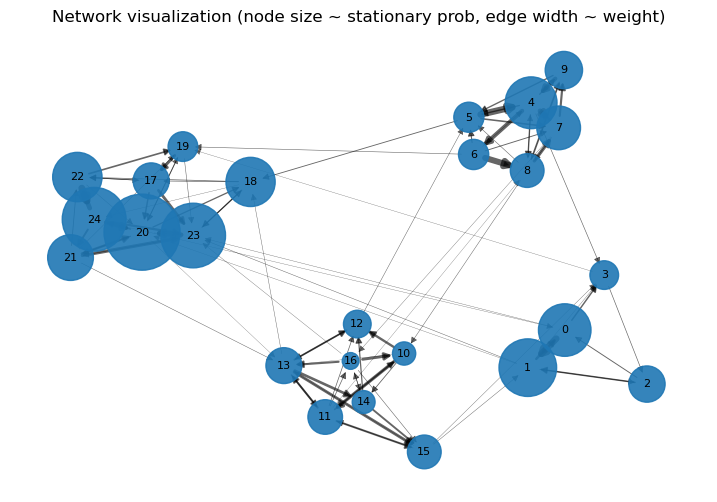

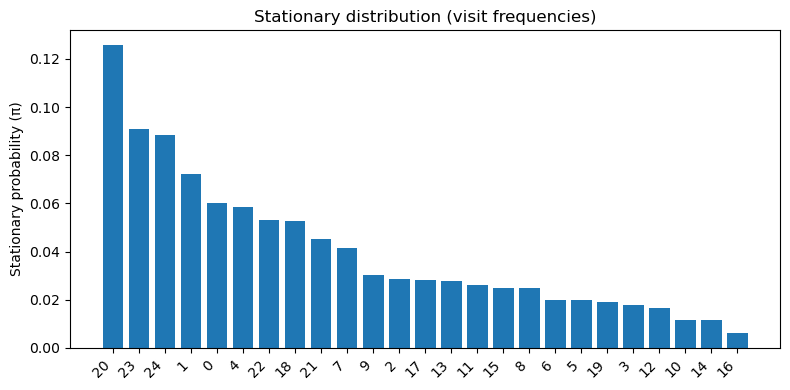

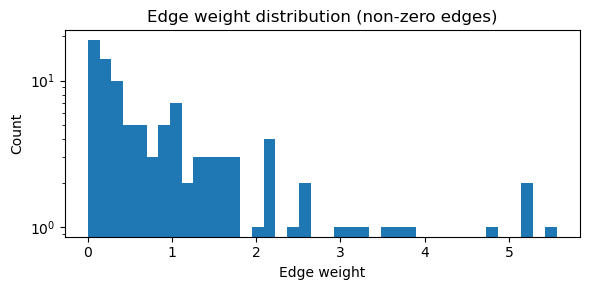

In [9]:
if __name__ == "__main__":
    # Example usage if you generated A, pi, partition earlier in the notebook:
    # If you used networkx conversion helpers, you might have: A, node_list, node_to_idx = graphnx_to_csr_and_mapping(G)
    try:
        # If your notebook already defines A, pi and partition, these calls will work.
        plot_network(A, pi=pi, partition=parse_partition(partition, A.shape[0]) if 'partition' in globals() else None,
                     node_list=globals().get('node_list', None))
    except Exception as e:
        print("plot_network example skipped (A or pi or partition not defined). Error:", e)

    # If you have pi:
    if 'pi' in globals():
        plot_stationary(pi, node_list=globals().get('node_list', None), top_k=30)

    # If you have A and partition:
    if 'A' in globals() and 'partition' in globals():
        plot_module_stats(A, partition, pi=globals().get('pi', None))

    # edge weights:
    if 'A' in globals():
        plot_edge_weight_distribution(A)


### Greedy Search for community detection

In [10]:
def merge_labels_array(part_arr, a, b):
    """
    Return a new partition array where modules with label b are remapped to label a,
    and labels are then renormalized to 0..m-1 (compact).
    Accepts integer labels in part_arr.
    """
    arr = np.asarray(part_arr, dtype=int).copy()
    if a == b:
        return normalize_partition_labels(arr)
    # map label b -> a
    arr[arr == b] = a
    # If some labels > b, they remain same; now renormalize
    return normalize_partition_labels(arr)

def compute_all_pair_merges_L(A, current_part, pi, epsilon=0.15):
    """
    For a given partition (array), compute L for every possible unordered pair of distinct modules
    produced by merging them. Returns:
      - best_L_for_pair: dict keyed by (i,j) tuple (i<j) -> L_after_merge
    Note: this re-evaluates map_equation_L for each candidate merge (simple but expensive).
    """
    modules = np.unique(current_part)
    m = modules.size
    results = {}
    # iterate unordered pairs
    for i_idx in range(m):
        for j_idx in range(i_idx+1, m):
            i = modules[i_idx]
            j = modules[j_idx]
            new_part = merge_labels_array(current_part, i, j)
            L_new = map_equation_L(A, new_part, pi=pi, epsilon=epsilon)
            results[(i,j)] = L_new
    return results

def greedy_agglomerative_map(A,
                             pi=None,
                             epsilon=0.15,
                             min_merge_gain=1e-12,
                             max_iters=None,
                             verbose=True):
    """
    Greedy agglomerative merging to minimize map-equation L.
    Parameters
    - A: adjacency (csr or ndarray)
    - pi: optional stationary distribution; if None, computed with power_method_stationary
    - epsilon: teleport probability for map_equation_L / power_method
    - min_merge_gain: require (L_before - L_after) > min_merge_gain to accept a merge
    - max_iters: maximum number of merges to perform (None -> up to m-1)
    Returns
    - final_partition: array length n mapping node->module
    - history: list of dicts for each step with keys:
        {'step', 'num_modules', 'L', 'merged_pair', 'L_before', 'L_after', 'gain', 'partition'}
      partition in history is a copy of the partition array after the merge
    """
    # ensure A shape and n
    if hasattr(A, "shape"):
        n = A.shape[0]
    else:
        A = np.asarray(A)
        n = A.shape[0]

    if pi is None:
        if verbose:
            print("Computing stationary distribution pi...")
        pi = power_method_stationary(A, epsilon=epsilon)

    # start each node in its own module
    part = np.arange(n, dtype=int)
    part = normalize_partition_labels(part)  # would be same but keep stable ordering
    current_L = map_equation_L(A, part, pi=pi, epsilon=epsilon)
    history = []
    step = 0
    if verbose:
        print(f"Initial L = {current_L:.6f}, n_modules = {np.unique(part).size}")

    # limit iterations to at most n-1 merges
    max_possible = n - 1
    if max_iters is None:
        max_iters = max_possible
    else:
        max_iters = min(max_iters, max_possible)

    # main loop
    while True:
        modules = np.unique(part)
        m = modules.size
        if verbose:
            print(f"\nStep {step}: trying merges among {m} modules")

        # stop condition: can't merge if only one module remains
        if m <= 1 or step >= max_iters:
            if verbose:
                print("Stopping: only one module left or reached max_iters.")
            break

        # compute L for all pairwise merges
        pair_Ls = compute_all_pair_merges_L(A, part, pi, epsilon=epsilon)

        # find best (lowest L)
        best_pair, best_L = min(pair_Ls.items(), key=lambda kv: kv[1])
        best_gain = current_L - best_L

        if verbose:
            print(f"Best candidate merge {best_pair} -> L_after={best_L:.6f} (gain {best_gain:.6e})")

        # accept best merge only if it improves L by at least min_merge_gain
        if best_gain <= min_merge_gain:
            if verbose:
                print("No merge improves L by more than min_merge_gain. Stopping.")
            break

        # apply merge
        a, b = best_pair
        new_part = merge_labels_array(part, a, b)
        step += 1
        part = new_part
        L_before = current_L
        current_L = best_L

        history.append({
            'step': step,
            'num_modules': np.unique(part).size,
            'L': current_L,
            'merged_pair': (a,b),
            'L_before': L_before,
            'L_after': current_L,
            'gain': L_before - current_L,
            'partition': part.copy()
        })

        if verbose:
            print(f"Applied merge {a}<-{b}. New L = {current_L:.6f}, modules = {np.unique(part).size}")

    # done
    final_part = normalize_partition_labels(part)
    return final_part, history

In [11]:
H= nx.read_graphml("/Users/pacte/Documents/UNI/Physics_of_data/workspace/InfoTheory/Texas.graphml")

print(len(nx.nodes(H)))

254


In [ ]:
A = nx.adjacency_matrix(H)

# compute pi (if not already computed)
pi = power_method_stationary(A, epsilon=0.15)

# run greedy agglomerative search (small graphs: fine)
final_partition, history = greedy_agglomerative_map(A, pi=pi, epsilon=0.15, min_merge_gain=1e-10, verbose=True)

print("\n\nFinal number of modules:", np.unique(final_partition).size)
print("Final L:", map_equation_L(A, final_partition, pi=pi, epsilon=0.15))

print("L from ground truth: ", L_val)

# view merge history (L vs step)
Ls = [h['L'] for h in history]
nums = [h['num_modules'] for h in history]
print("History (last 5 steps):")
for h in history[-5:]:
    print(h['step'], h['merged_pair'], "gain", h['gain'], "L", h['L'])


Initial L = 9.729443, n_modules = 254

Step 0: trying merges among 254 modules
Best candidate merge (189, 222) -> L_after=9.666761 (gain 6.268263e-02)
Applied merge 189<-222. New L = 9.666761, modules = 253

Step 1: trying merges among 253 modules
Best candidate merge (56, 204) -> L_after=9.617421 (gain 4.934017e-02)
Applied merge 56<-204. New L = 9.617421, modules = 252

Step 2: trying merges among 252 modules


In [ ]:
def plot_partitioned_network(A, partition, pi=None, node_list=None,
                             figsize=(9,6), layout_seed=42, edge_width_scale=4.0, node_size_scale=2400):
    """
    Draw network with nodes colored by `partition` (array-like node->module).
    Node sizes ~ pi (if provided), edge widths ~ weights.
    """
    if not issparse(A):
        A = csr_matrix(A)
    n = A.shape[0]
    part = np.asarray(partition, dtype=int)
    # Build networkx DiGraph (for plotting)
    G = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)
    # layout from undirected version for stability
    pos = nx.spring_layout(G.to_undirected(), seed=layout_seed)

    # node sizes
    if pi is None:
        sizes = np.ones(n) * (node_size_scale / max(n,1))
    else:
        pi = np.asarray(pi, dtype=float)
        # normalize pi to [0.02, 1] then scale
        scaled = (pi - pi.min()) / (pi.max() - pi.min() + 1e-16)
        scaled = 0.02 + scaled * 0.98
        sizes = scaled * node_size_scale

    # node colors by module with tab20 palette
    unique_mods = np.unique(part)
    cmap = plt.get_cmap('tab20')
    color_map = {m: cmap(i % 20) for i, m in enumerate(unique_mods)}
    node_colors = [color_map[int(part[i])] for i in range(n)]

    # edge widths from weights
    weights = [d.get('weight', 1.0) for _,_,d in G.edges(data=True)]
    if len(weights) > 0 and max(weights) > 0:
        w = np.array(weights, dtype=float)
        ew = 0.2 + (w - w.min())/(w.max() - w.min() + 1e-16) * (edge_width_scale - 0.2)
    else:
        ew = 0.6

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.95)
    nx.draw_networkx_edges(G, pos, width=ew, alpha=0.5, arrowsize=10)
    # show labels if small
    if n <= 60:
        labels = {i: (str(node_list[i]) if node_list is not None else str(i)) for i in range(n)}
        nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title("Network (colors = detected modules, size ~ π)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def plot_greedy_history(history, figsize=(10,6)):
    """
    Plots: L vs step, #modules vs step, gain per step.
    Expects `history` from greedy_agglomerative_map (list of dicts).
    """
    if not history:
        print("Empty history: no merges performed.")
        return

    steps = [0] + [h['step'] for h in history]
    # L at step 0 is initial L (we can reconstruct it)
    Ls = []
    nums = []
    gains = []
    # initial values
    # try to reconstruct initial L: if first history item has L_before use it
    L0 = history[0].get('L_before', None)
    if L0 is None:
        L0 = history[0]['L'] + history[0].get('gain', 0.0)
    Ls.append(L0)
    nums.append(history[0].get('num_modules', None) + 1 if history[0].get('num_modules', None) is not None else None)
    gains.append(0.0)

    for h in history:
        Ls.append(h['L'])
        nums.append(h['num_modules'])
        gains.append(h.get('gain', 0.0))

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    axs[0].plot(steps, Ls, marker='o')
    axs[0].set_xlabel('merge step')
    axs[0].set_ylabel('L (bits/step)')
    axs[0].set_title('Description length L vs merge step')
    axs[0].grid(True)

    axs[1].plot(steps, nums, marker='o')
    axs[1].set_xlabel('merge step')
    axs[1].set_ylabel('number of modules')
    axs[1].set_title('#Modules vs merge step')
    axs[1].invert_xaxis()   # optional: show decreasing modules from left->right (uncomment if preferred)
    axs[1].grid(True)

    axs[2].bar(steps, gains)
    axs[2].set_xlabel('merge step')
    axs[2].set_ylabel('gain (L_before - L_after)')
    axs[2].set_title('Gain per merge')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


def plot_sorted_adjacency(A, partition, vmax=None, figsize=(6,6), max_dense=800):
    """
    Plot adjacency matrix with nodes sorted by module (blocks grouped). If n > max_dense,
    use sparse spy plotting to avoid dense memory blow-up.
    """
    if not issparse(A):
        A = csr_matrix(A)
    n = A.shape[0]
    part = np.asarray(partition, dtype=int)
    order = np.argsort(part)  # groups nodes by module

    if n <= max_dense:
        Ad = A.toarray()
        Ads = Ad[np.ix_(order, order)]
        plt.figure(figsize=figsize)
        plt.imshow(Ads, aspect='auto', interpolation='nearest', cmap='viridis', vmax=vmax)
        # draw module boundaries
        cuts = np.where(np.diff(part[order]) != 0)[0]
        for c in cuts:
            plt.axhline(c + 0.5, color='w', linewidth=0.8)
            plt.axvline(c + 0.5, color='w', linewidth=0.8)
        plt.colorbar(label='edge weight')
        plt.title('Adjacency (nodes sorted by module)')
        plt.xlabel('nodes (sorted)')
        plt.ylabel('nodes (sorted)')
        plt.tight_layout()
        plt.show()
    else:
        # sparse visualization for large graphs
        plt.figure(figsize=figsize)
        # permute rows/cols and plot spy
        Apr = A[order,:][:,order]
        # show non-zero structure
        plt.spy(Apr, markersize=1)
        plt.title('Adjacency (sparse spy) - nodes sorted by module')
        plt.tight_layout()
        plt.show()


def plot_module_sizes(partition, figsize=(6,3)):
    part = np.asarray(partition, dtype=int)
    mods, counts = np.unique(part, return_counts=True)
    plt.figure(figsize=figsize)
    plt.bar(mods.astype(str), counts)
    plt.xlabel('module')
    plt.ylabel('size (nodes)')
    plt.title('Module sizes')
    plt.tight_layout()
    plt.show()

Plotting detected communities on network...


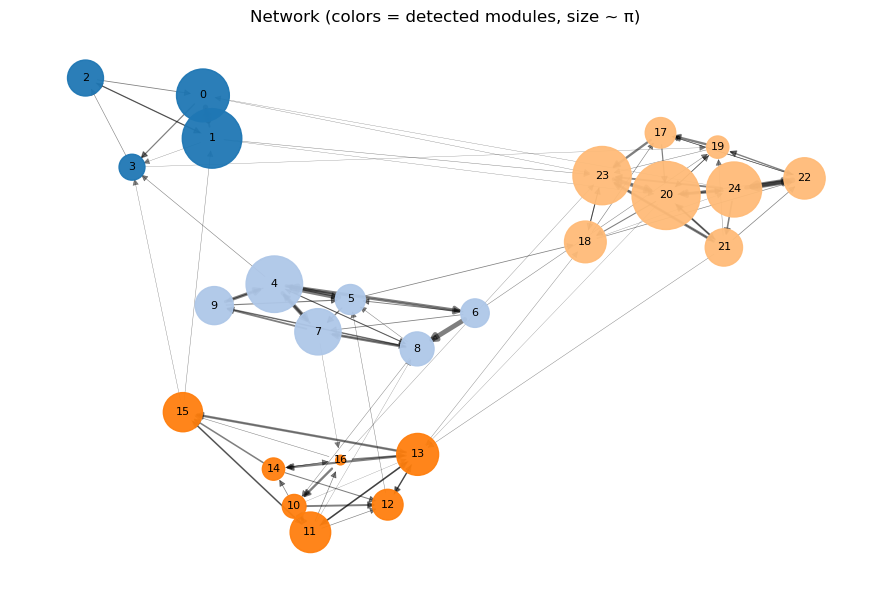

Plotting greedy search diagnostics...


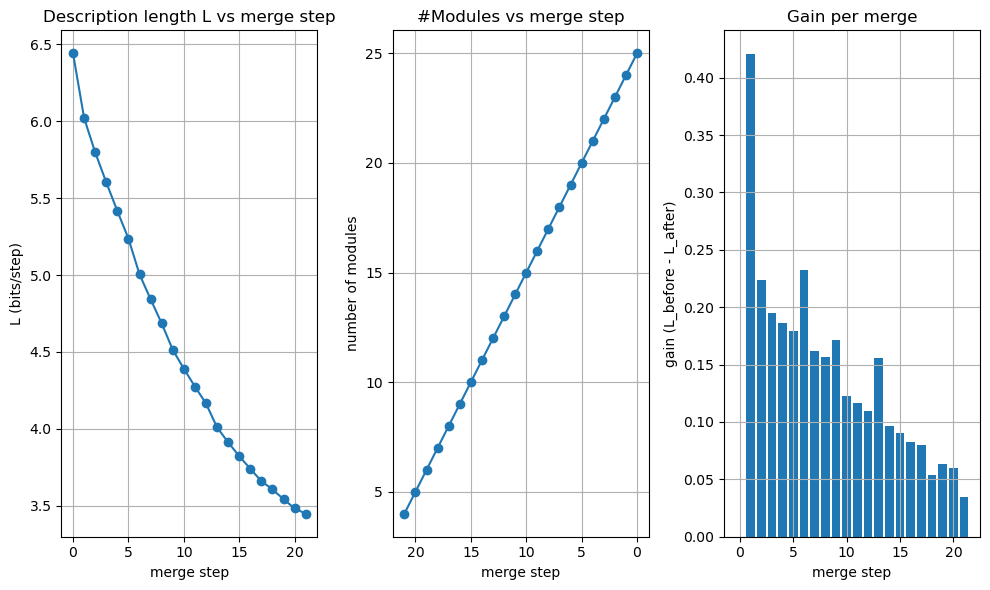

Plotting adjacency sorted by module (may switch to sparse view for large graphs)...


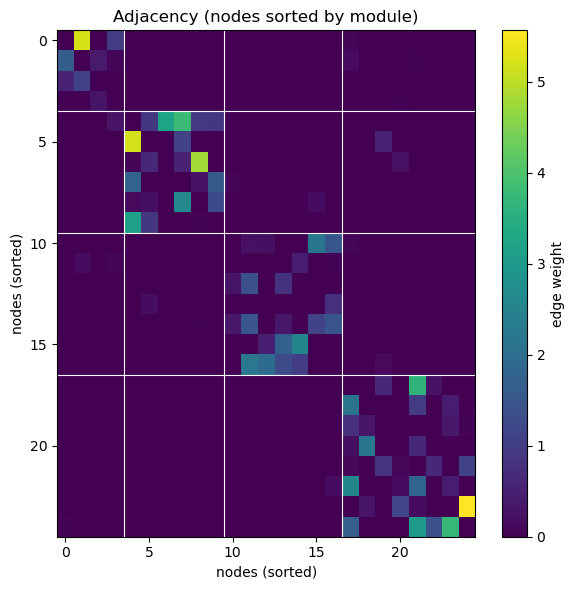

Plotting module sizes...


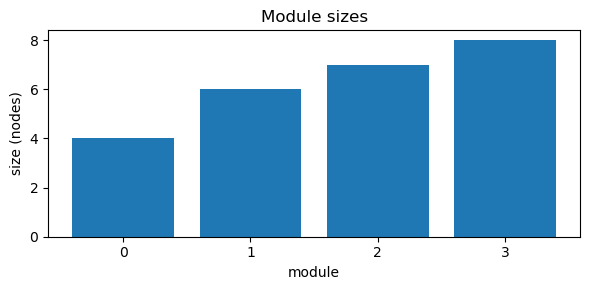

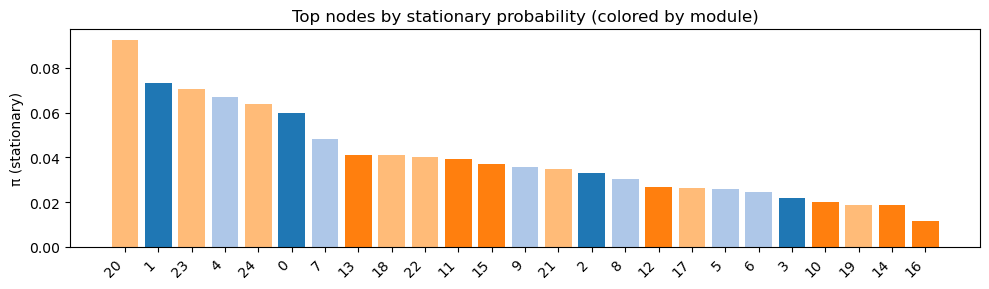

In [ ]:
# -------------------------
# Example of usage (run after greedy_agglomerative_map)
# -------------------------
# required: final_partition, history, A, and optionally pi, node_list
try:
    # If you used array partition, final_partition should be array-like.
    print("Plotting detected communities on network...")
    plot_partitioned_network(A, final_partition, pi=globals().get('pi', None), node_list=globals().get('node_list', None))

    print("Plotting greedy search diagnostics...")
    plot_greedy_history(history)

    print("Plotting adjacency sorted by module (may switch to sparse view for large graphs)...")
    plot_sorted_adjacency(A, final_partition)

    print("Plotting module sizes...")
    plot_module_sizes(final_partition)

    # optional: show stationary distribution colored by module (top nodes)
    if 'pi' in globals():
        try:
            # show top-20 by pi and color label by module
            pi_arr = np.asarray(pi)
            order = np.argsort(pi_arr)[::-1]
            topk = min(30, len(pi_arr))
            top_idx = order[:topk]
            top_vals = pi_arr[top_idx]
            top_mods = np.asarray(final_partition)[top_idx]
            cmap = plt.get_cmap('tab20')
            colors = [cmap(int(m) % 20) for m in top_mods]

            plt.figure(figsize=(10,3))
            plt.bar(range(topk), top_vals, color=colors)
            plt.xticks(range(topk), [str(globals().get('node_list',[i for i in range(len(pi_arr))])[idx]) for idx in top_idx], rotation=45, ha='right')
            plt.ylabel('π (stationary)')
            plt.title('Top nodes by stationary probability (colored by module)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Skipped top-pi plot:", e)

except Exception as e:
    print("Plotting skipped because required variables are missing or an error occurred:", e)


---

In [ ]:
def extract_map_codebooks(A, partition, pi, epsilon=0.15):
    """
    From adjacency A, partition (node->module array), and stationary pi,
    compute q_i, p_i and build the two-level codebooks implied by the map equation.
    Returns dict with:
      - 'q_i', 'p_i', 'q_total'
      - 'index_codebook': {module: {'prob':, 'len':}}
      - 'local_codebooks': {module: [{'token':, 'prob':, 'len':}, ...]}
      - 'L': total description length (bits/step)
    """
    comps = map_equation_L(A, partition, pi=pi, epsilon=epsilon, return_components=True)
    q_i = comps['q_i']
    p_i = comps['p_i']
    q_total = comps['q_total']
    H_Q = comps['H_Q']
    H_Pi = comps['H_Pi']
    L = comps['L']
    part_arr = np.asarray(partition, dtype=int)
    modules = np.unique(part_arr)

    # index (module) codebook: probabilities for module names in the index codebook:
    index_codebook = {}
    if q_total > 0:
        for j in modules:
            prob = float(q_i[j] / q_total) if q_total > 0 else 0.0
            length = -np.log2(prob) if prob > 0 else np.inf
            index_codebook[int(j)] = {'prob': prob, 'len_bits': length}
    else:
        # degenerate: no exits at all, index codebook not used
        for j in modules:
            index_codebook[int(j)] = {'prob': 0.0, 'len_bits': 0.0}

    # local codebooks: for each module j build list: exit symbol (if q_i>0) then nodes
    local_codebooks = {}
    for j in modules:
        entries = []
        pj = float(p_i[j])
        # exit symbol
        if pj > 0 and q_i[j] > 0:
            prob_exit = float(q_i[j] / pj)
            len_exit = -np.log2(prob_exit)
            entries.append({'token': '<exit>', 'prob': prob_exit, 'len_bits': len_exit})
        elif pj > 0:
            # no exit mass
            entries.append({'token': '<exit>', 'prob': 0.0, 'len_bits': 0.0})

        # node symbols
        nodes_in_j = np.where(part_arr == j)[0]
        for a in nodes_in_j:
            prob_node = float(pi[a] / pj) if pj > 0 else 0.0
            len_node = -np.log2(prob_node) if prob_node > 0 else np.inf
            entries.append({'token': int(a), 'prob': prob_node, 'len_bits': len_node})
        local_codebooks[int(j)] = entries

    return {
        'q_i': q_i,
        'p_i': p_i,
        'q_total': q_total,
        'index_codebook': index_codebook,
        'local_codebooks': local_codebooks,
        'H_Q': H_Q,
        'H_Pi': H_Pi,
        'L': L
    }

def print_codebooks_summary(codebooks, top_nodes_per_module=5, show_all_nodes=False):
    """
    Pretty-print summary: index codebook and first few entries of each local codebook.
    """
    print(f"Total L = {codebooks['L']:.6f} bits/step  (q_total = {codebooks['q_total']:.6e})\n")
    print("Index codebook (module name probabilities and lengths):")
    for mod, info in sorted(codebooks['index_codebook'].items()):
        print(f"  module {mod:2d}: prob={info['prob']:.6f}, len={info['len_bits']:.3f} bits")
    print("\nPer-module local codebooks (exit first, then top nodes by local prob):")
    for mod, entries in sorted(codebooks['local_codebooks'].items()):
        print(f"\nModule {mod}: p_i={codebooks['p_i'][mod]:.6e}, q_i={codebooks['q_i'][mod]:.6e}")
        # show exit
        for e in entries[:1]:
            print(f"  token={e['token']:>6s} prob={e['prob']:.6f} len={e['len_bits']:.3f}")
        # show top nodes by prob
        node_entries = [e for e in entries if isinstance(e['token'], int)]
        node_entries_sorted = sorted(node_entries, key=lambda x: -x['prob'])

        for e in node_entries_sorted[:top_nodes_per_module]:
            print(f"  node {e['token']:3d}: prob_local={e['prob']:.6f}, len={e['len_bits']:.3f} bits")

1.0

In [ ]:
codebooks = extract_map_codebooks(A, final_partition, pi, epsilon=0.15)
print_codebooks_summary(codebooks, top_nodes_per_module=np.max(sizes))

Total L = 3.448599 bits/step  (q_total = 1.436662e-01)

Index codebook (module name probabilities and lengths):
  module  0: prob=0.225094, len=2.151 bits
  module  1: prob=0.225584, len=2.148 bits
  module  2: prob=0.260777, len=1.939 bits
  module  3: prob=0.288545, len=1.793 bits

Per-module local codebooks (exit first, then top nodes by local prob):

Module 0: p_i=2.196615e-01, q_i=3.233837e-02
  token=<exit> prob=0.147219 len=2.764
  node   1: prob_local=0.332511, len=1.589 bits
  node   0: prob_local=0.271376, len=1.882 bits
  node   2: prob_local=0.149717, len=2.740 bits
  node   3: prob_local=0.099176, len=3.334 bits

Module 1: p_i=2.634656e-01, q_i=3.240877e-02
  token=<exit> prob=0.123010 len=3.023
  node   4: prob_local=0.253637, len=1.979 bits
  node   7: prob_local=0.182386, len=2.455 bits
  node   9: prob_local=0.135437, len=2.884 bits
  node   8: prob_local=0.115271, len=3.117 bits
  node   5: prob_local=0.098083, len=3.350 bits
  node   6: prob_local=0.092177, len=3.439